In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [47]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [48]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [49]:
%%R
physeq = subset_samples(physeq,sample_sums(physeq)>1000)
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
#physeq = transform_sample_counts(physeq, function(x) x / sum(x))
#physeq = subset_samples(physeq, Trtmt!="Heavy Fraction")
#physeq = subset_samples(physeq, Trtmt!="Kaolinite")
#physeq = subset_samples(physeq, Trtmt!="Blank")
#physeq = subset_samples(physeq, Trtmt!="Quartz")
#physeq = subset_samples(physeq, Trtmt!="Ferrihydrite")
#physeq = subset_samples(physeq, Trtmt!="Soil")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

Error in round(z[, "p adj"], digits) : 
  non-numeric argument to mathematical function
In addition: There were 40 warnings (use warnings() to see them)
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                              diff          lwr          upr     p adj
Kaolinite-Ferrihydrite  0.07926456 -0.008225612  0.166754727 0.0888674
Quartz-Ferrihydrite     0.03403776 -0.031433890  0.099509406 0.5183134
Soil-Ferrihydrite      -0.02913592 -0.097803166  0.039531321 0.6759838
Quartz-Kaolinite       -0.04522680 -0.132716969  0.042263370 0.5231466
Soil-Kaolinite         -0.10840048 -0.198307006 -0.018493954 0.0121066
Soil-Quartz            -0.06317368 -0.131840924  0.005493563 0.0818277



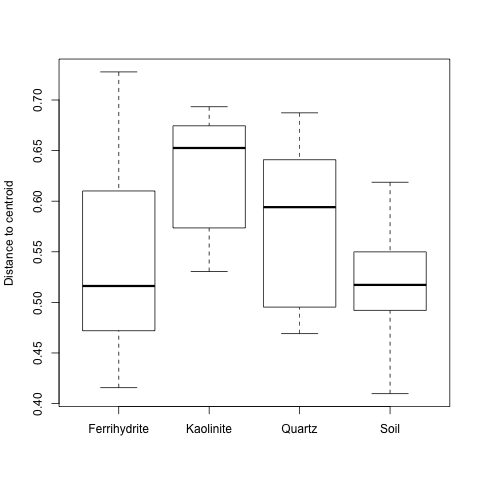

In [55]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Trtmt)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here. Some worry re. Kaolinite, as expected.

In [30]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")

d.adonis = adonis(d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(physeq)$Month  1    0.6016 0.60157  2.1298 0.05569  0.003 ** 
sample_data(physeq)$Trtmt  1    0.8789 0.87895  3.1119 0.08137  0.001 ***
Residuals                 33    9.3209 0.28245         0.86293           
Total                     35   10.8014                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is a significant effect of both month and treatment, across samples

In [10]:
%%R
physeq.QS = subset_samples(physeq, Trtmt == c("Soil","Quartz"))
physeq.FS = subset_samples(physeq, Trtmt == c("Soil","Ferrihydrite"))
physeq.QF = subset_samples(physeq, Trtmt == c("Quartz","Ferrihydrite"))

In [11]:
%%R
ps = physeq.QS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1    0.4073 0.40732  1.5194 0.08266  0.064 .  
sample_data(ps)$Trtmt  1    0.7670 0.76696  2.8610 0.15565  0.001 ***
Residuals             14    3.7531 0.26808         0.76168           
Total                 16    4.9274                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [12]:
%%R
ps = physeq.FS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1    0.3179 0.31789  1.2050 0.06117  0.222    
sample_data(ps)$Trtmt  1    1.1860 1.18596  4.4955 0.22819  0.001 ***
Residuals             14    3.6933 0.26381         0.71064           
Total                 16    5.1972                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
%%R
ps = physeq.QF
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
sample_data(ps)$Month  1    0.3899 0.38993  1.3474 0.07536  0.099 .
sample_data(ps)$Trtmt  1    0.4435 0.44346  1.5324 0.08570  0.023 *
Residuals             15    4.3409 0.28939         0.83894         
Total                 17    5.1743                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
